# Final Project for INF8225

## InfoGan

#### Bruno Curzi-Laliberté, Thomas Rochefort-Beaudoin, Antoine Martin & Lucas Aubrun

In [1]:
# for Keras
import tensorflow

In [2]:
# for splitting keras Dataset, scikit learn has an easy way: sklearn.model_selection.train_test_split(...)
import sklearn.model_selection

In [3]:
# For creating tensors easily, also includes random tensors with np.random
import numpy as np

In [4]:
# For displaying graphs, MNIST images & GAN images
import matplotlib.pyplot as plt

In [5]:
# https://github.com/tensorflow/tensorflow/issues/46038
config = tensorflow.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tensorflow.compat.v1.Session(config=config)

In [6]:
# https://stackoverflow.com/a/59568642/10945691
import subprocess as sp
import os

def get_gpu_memory():
    ACCEPTABLE_AVAILABLE_MEMORY = 1024
    COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(COMMAND.split()).decode('ascii').split('\n')[1:-1]
    memory_free_values = [int(x.split()[0]) for x in memory_free_info]
    return memory_free_values

# After building 1 model from Keras, this value will drop by 4-5GB, not sure why Keras allocates so much
get_gpu_memory()

[5303]

In [7]:
seed = 8225
batch = 256
half = batch//2
nsub = 54000 // batch

In [8]:
# MNIST
(kerasTrainX, kerasTrainY), (kerasTestX, kerasTestY) = tensorflow.keras.datasets.mnist.load_data(path="mnist.npz")
kerasTrainX, kerasValidX, kerasTrainY, kerasValidY = sklearn.model_selection.train_test_split(kerasTrainX, kerasTrainY, test_size=0.1, shuffle=True, random_state=seed)

In [9]:
# Won't work if we don't scale down the values to [0, 1[

kerasTrainX = kerasTrainX.reshape(54000, 28, 28, 1) / 256
kerasValidX = kerasValidX.reshape( 6000, 28, 28, 1) / 256
kerasTestX  = kerasTestX .reshape(10000, 28, 28, 1) / 256

In [10]:
# https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

def Generator(latentDimension):
    generator = tensorflow.keras.models.Sequential()
    # foundation for 7x7 image, not 28x28
    n_nodes = 128 * 7 * 7
    generator.add(tensorflow.keras.layers.Dense(n_nodes, input_dim=latentDimension))
    generator.add(tensorflow.keras.layers.LeakyReLU(alpha=0.2))
    generator.add(tensorflow.keras.layers.Reshape((7, 7, 128)))
    # upsample to 14x14
    generator.add(tensorflow.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    generator.add(tensorflow.keras.layers.LeakyReLU(alpha=0.2))
    # upsample to 28x28
    generator.add(tensorflow.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    generator.add(tensorflow.keras.layers.LeakyReLU(alpha=0.2))
    generator.add(tensorflow.keras.layers.Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return generator

In [11]:
# https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

def Discriminator():
    discriminator = tensorflow.keras.models.Sequential()
    discriminator.add(tensorflow.keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    discriminator.add(tensorflow.keras.layers.LeakyReLU(alpha=0.2))
    discriminator.add(tensorflow.keras.layers.Dropout(0.4))
    discriminator.add(tensorflow.keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    discriminator.add(tensorflow.keras.layers.LeakyReLU(alpha=0.2))
    discriminator.add(tensorflow.keras.layers.Dropout(0.4))
    discriminator.add(tensorflow.keras.layers.Flatten())
    discriminator.add(tensorflow.keras.layers.Dense(1, activation='sigmoid'))
    opt = tensorflow.keras.optimizers.Adam(lr=0.0002, beta_1=0.5) # 0.5 is interesting
    discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return discriminator

In [12]:
# https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

def GAN(G, D):
    D.trainable = False
    gan = tensorflow.keras.models.Sequential([G, D])
    opt = tensorflow.keras.optimizers.Adam(lr=0.0002, beta_1=0.5) # 0.5 is interesting
    gan.compile(loss='binary_crossentropy', optimizer=opt)
    return gan

In [13]:
latentDimension = 100

In [14]:
generator = Generator(latentDimension)

In [15]:
discriminator = Discriminator()

In [16]:
gan = GAN(generator, discriminator)

In [17]:
# https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

def train(g, d, gan, latent_dim, n_epochs=20):
    for epoch in range(n_epochs):
        print(f'epoch {epoch + 1}')
        for j in range(nsub):
            GX, GY = g.predict(np.random.randn(latent_dim * half).reshape(half, latent_dim)), np.zeros((half, 1))
            DX, DY =  kerasTrainX[np.random.randint(0, kerasTrainX.shape[0], half)], np.ones((half, 1))
            d.train_on_batch(np.vstack((GX, DX)), np.vstack((GY, DY)))
            X_gan = np.random.randn(latent_dim, batch).reshape(batch, latent_dim)
            y_gan = np.ones((batch, 1))
            gan.train_on_batch(X_gan, y_gan)

train(generator, discriminator, gan, latentDimension)

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20


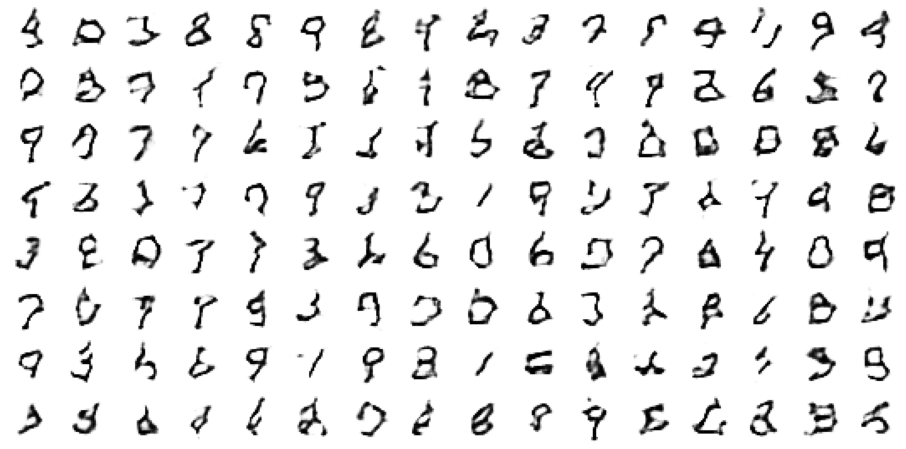

In [18]:
S = 8
X = generator.predict(np.random.randn(latentDimension * 2 * S * S).reshape((2 * S * S, latentDimension)))
plt.subplots(figsize=(2*S, S))
for i in range(2 * S * S):
    plt.subplot(S, 2 * S, 1 + i)
    plt.axis('off')
    plt.imshow(X[i, :, :, 0], cmap='gray_r')
plt.show()